In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import hist

In [2]:
cenns = uproot.open('../data/ar40_0comp.root:CENNS')
# data = cenns.arrays(['ev_en', 'ch1_photontimes', 'ch3_photontimes'], library='np')
data = cenns.arrays(['ev_en', 'ch1_photontimes', 'ch3_photontimes'])

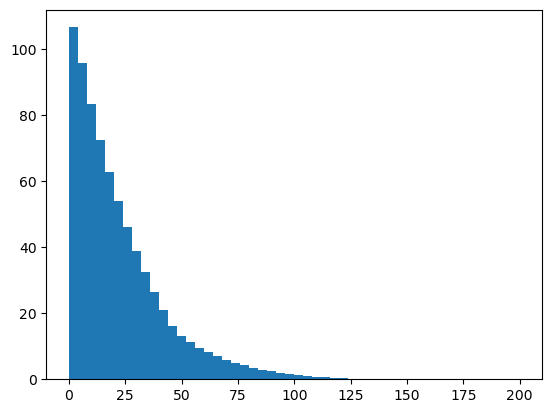

In [3]:
d = np.loadtxt('../data/sns_diff_rates-cenns10_ben-Ar-klein-Ar40.out')
x = d[:, 0] * 1000
y = d[:, 1] / 1000 * np.diff(x)[0]
h1 = hist.Hist(hist.axis.Regular(50, 0, 200))
h1.fill(x, weight=y)
h, e = h1.to_numpy()
plt.stairs(h, e, fill=True)

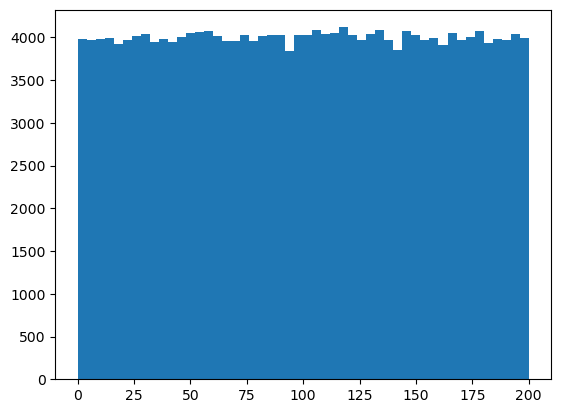

In [4]:
h2 = hist.Hist(hist.axis.Regular(50, 0, 200))
h2.fill(data['ev_en'])
h, e = h2.to_numpy()
plt.stairs(h, e, fill=True)

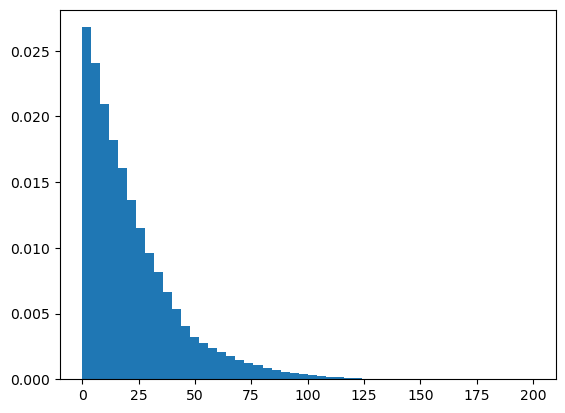

In [5]:
h3 = h1 / h2
h, e = h3.to_numpy()
plt.stairs(h, e, fill=True)

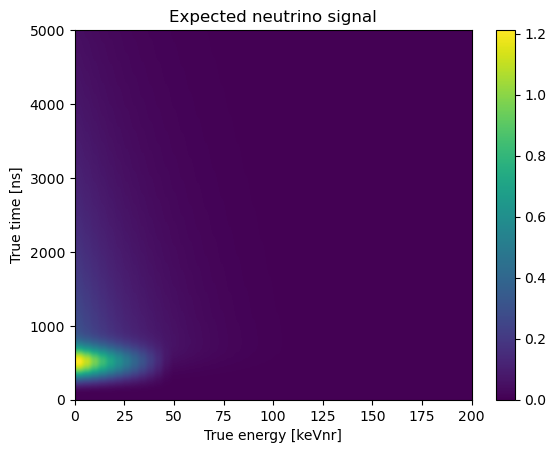

In [6]:
h4 = hist.Hist(hist.axis.Regular(50, 0, 200, name='True energy [keVnr]'), 
               hist.axis.Regular(500, 0, 5000, name='True time [ns]'))
for i in range(0, 500):
    d = np.loadtxt(f'../data/sns_diff_rates-cenns10_ben_{i}-Ar-klein-Ar40.out')
    x = d[:, 0] * 1000
    y = d[:, 1] / 1000 * np.diff(x)[0]
    h = hist.Hist(hist.axis.Regular(50, 0, 200))
    h.fill(x, weight=y)
    vals = h.counts()
    h4.fill(h.axes[0].centers, i * 10, weight=vals)
plt.title('Expected neutrino signal')
plt.ylabel('True time [ns]')
plt.xlabel('True energy [keVnr]')
p, ex, ey = h4.to_numpy()
plt.imshow(p.T, origin='lower', aspect='auto', extent=[ex[0], ex[-1], ey[0], ey[-1]])
plt.colorbar()

Text(0, 0.5, 'Events')

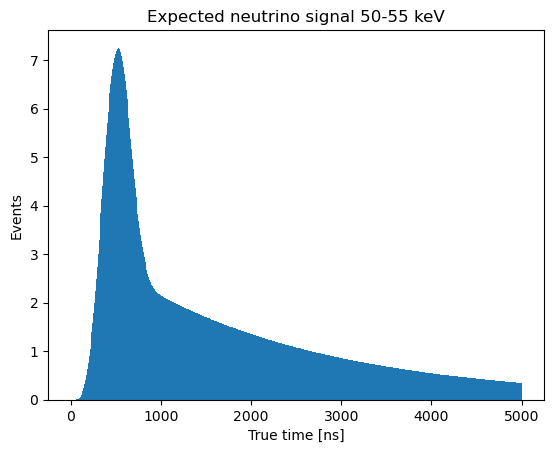

In [7]:
h4[hist.loc(50):hist.loc(55), :].project(1).plot(fill=True)
plt.title("Expected neutrino signal 50-55 keV")
plt.ylabel("Events")

In [8]:
rng = np.random.default_rng(1234)
coinc = 90.0
dist = 27.5
sol = 0.2998
tt_m = 54.0
tt_s = 2.4 / 2.335
tn_t = 212.0
hardware_t = 205.4
econv = 5.06
# h5 = hist.Hist(hist.axis.Regular(40, 0, 200), 
#                hist.axis.Regular(60, -1000, 5000),
#                hist.axis.Regular(40, 0.5, 0.9))
h5 = hist.Hist(hist.axis.Regular(40, 0, 200), 
               hist.axis.Regular(60, -1000, 5000))
reco_ens = []
reco_times = []
# f90s = []
weights = []

# for en, ch1, ch3 in list(zip(data['ev_en'], data['ch1_photontimes'], data['ch3_photontimes'])):
for event in data:
  en = event['ev_en']
  ch1 = np.sort(event['ch1_photontimes'])
  ch3 = np.sort(event['ch3_photontimes'])
  # ch1.sort()
  # ch3.sort()
  ch1_s = rng.normal(1.0, 0.4, len(ch1))
  ch3_s = rng.normal(1.0, 0.4, len(ch3))
  pes_top = np.sum(ch1_s[ch1 < 6000])
  pes_bot = np.sum(ch3_s[ch3 < 6000])
  singlets = np.sum(ch1_s[ch1 < 90])
  singlets += np.sum(ch3_s[ch3 < 90])

  if len(ch1) > 2 and len(ch3) > 2:
    t0 = min(ch1[0], ch3[0])
    if abs(ch1[0] - ch3[0]) > 20:
      continue
    if ch1[0] - t0 > coinc or ch1[1] - t0 > coinc:
      continue
    if ch3[0] - t0 > coinc or ch3[1] - t0 > coinc:
      continue
  else:
    continue

  # f90 = singlets / (pes_top + pes_bot)
  # if f90 < 0.5 or f90 > 0.9:
  #   continue

  timeslice = h4[hist.loc(en-5.0):hist.loc(en+5.0), :].project(1)
  prob = timeslice.values() / timeslice.sum()
  nu_time = rng.choice(timeslice.axes[0].centers, p=prob) - 125.0
  reco_time = t0 + nu_time + hardware_t
  reco_en = (pes_top + pes_bot) / econv
  reco_ens.append(reco_en)
  reco_times.append(reco_time)
  # f90s.append(f90)
  weights.append(h3[hist.loc(en)])
  # h5.fill(reco_en, reco_time, f90, weight=h3[hist.loc(en)])
  h5.fill(reco_en, reco_time, weight=h3[hist.loc(en)])
h5

Hist(
  Regular(40, 0, 200, label='Axis 0'),
  Regular(60, -1000, 5000, label='Axis 1'),
  storage=Double()) # Sum: 454.0683819500268 (455.7572392489346 with flow)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f0a9958c890>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f0a995a9670>, text=[])

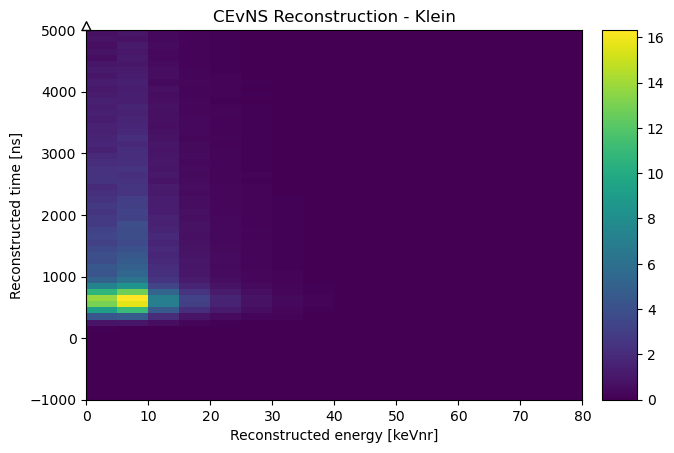

In [9]:
plt.title('CEvNS Reconstruction - Klein')
plt.ylabel('Reconstructed time [ns]')
plt.xlabel('Reconstructed energy [keVnr]')
h5[0j:80j, :].plot2d()
# p, ex, ey, ez = h5[0j:80j, :, :].to_numpy()
# plt.imshow(p.T, origin='lower', aspect='auto', extent=[ex[0], ex[-1], ey[0], ey[-1]])
# plt.colorbar()

In [10]:
f = uproot.recreate("../data/cenns10_cevns.root")
f["cevns_pdf"] = h5
# f["cevns"] = { "en": reco_ens, "t": reco_times, "f90": f90s, "event_weights": weights }
f["cevns"] = { "en": reco_ens, "t": reco_times, "event_weights": weights }
f.close()